In [1]:
# Standard Imports
from __future__ import print_function
import numpy as np
import pandas as pd
import os
import sys
from collections import defaultdict
from importlib import reload
from bs4 import BeautifulSoup
import requests
import scipy.stats as scs
import time
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import keras.backend as K
from tensorflow.keras.constraints import min_max_norm, non_neg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load MongoDB
from pymongo import MongoClient
client = MongoClient()
# Access/Initiate Database
db = client['producer_db']
# Access/Initiate Table
mfcc_tab = db['mfcc']
tab = db['songs']
collection = db.tab
mfcc_collection = db.mfcc_tab

# Authorize Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_id = os.environ['SPOTIFY_CLIENT_ID']
client_secret = os.environ['SPOTIFY_CLIENT_SECRET']
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# # Audio Processing
# import librosa
# import librosa.display
# from IPython.display import Audio
# from scipy.io import wavfile
# from pydub import AudioSegment
# from src.audio_processing import load_mp3_from_url

Using TensorFlow backend.


In [45]:
a = collection.find_one()
a['track_info']

{'album': {'album_type': 'compilation',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2'},
    'href': 'https://api.spotify.com/v1/artists/3WrFJ7ztbogyGnTHbHJFl2',
    'id': '3WrFJ7ztbogyGnTHbHJFl2',
    'name': 'The Beatles',
    'type': 'artist',
    'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl2'}],
  'available_markets': ['AD',
   'AE',
   'AR',
   'AT',
   'AU',
   'BE',
   'BG',
   'BH',
   'BO',
   'BR',
   'CA',
   'CH',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DE',
   'DK',
   'DO',
   'DZ',
   'EC',
   'EE',
   'EG',
   'ES',
   'FI',
   'FR',
   'GB',
   'GR',
   'GT',
   'HK',
   'HN',
   'HU',
   'ID',
   'IE',
   'IL',
   'IN',
   'IS',
   'IT',
   'JO',
   'JP',
   'KW',
   'LB',
   'LI',
   'LT',
   'LU',
   'LV',
   'MA',
   'MC',
   'MT',
   'MX',
   'MY',
   'NI',
   'NL',
   'NO',
   'NZ',
   'OM',
   'PA',
   'PE',
   'PH',
   'PL',
   'PS',
   'PT',
   'PY',
   'QA',
   'RO',
   'SA',
   'SE',
   'SG',
   

In [49]:
genres = sp.artist(a['track_info']['artists'][0]['id'])['genres']
a['producer'], a['spotify_id']

('George Martin', '2HvTGx5fzFGpHSyRNvXd9T')

In [6]:
collection.find_one()['artist']

'the Beatles'

In [8]:
artist_genres = {}
for i, song in enumerate(collection.find()):
    artist = song['artist']
    if song['track_info']['preview_url'] != None:
        if artist in artist_genres.keys():
            genres = artist_genres[artist]
        else:
            genres = sp.artist(song['track_info']['artists'][0]['id'])['genres']
            artist_genres[artist] = genres
        myquery = {'producer':song['producer'],
                   'spotify_id':song['spotify_id']
                  }

        newvalues = {'$set': {'genres':genres}
                    }

        mfcc_collection.update_one(myquery, newvalues, upsert = False)
        
    if i%100 == 0:
        print (i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300


In [9]:
a_new = mfcc_collection.find_one()
a_new.keys()

dict_keys(['_id', 'producer', 'spotify_id', 'MFCC', 'album', 'artist', 'preview_url', 'songs_mongs_id', 'track', 'genres'])

In [11]:
a_new['track'], a_new['artist'], a_new['genres']

('Act Naturally', 'Buck Owens and the Buckaroos', ['traditional country'])

# Let's get some numbers on those genres and classify!

In [36]:
genre_list = []
genre_df = []
for song in mfcc_collection.find():
    try:
        genre_list += song['genres']
        genre_df.append( (song['artist'],song['track'],song['genres']) )
    except:
        pass
genre_list = np.array(genre_list).flatten()
genre_df = pd.DataFrame(genre_df, columns = ['artist','track','genres'])

In [37]:
genre_df.head()

,artist,track,genres
0,Buck Owens and the Buckaroos,Act Naturally,[traditional country]
1,Cilla Black,Alfie,"[adult standards, brill building pop, bubblegu..."
2,America,Amber Cascades,"[album rock, art rock, classic rock, country r..."
3,Dionne Warwick,Anyone Who Had a Heart,"[adult standards, brill building pop, christma..."
4,The Shirelles,Baby It's You,"[adult standards, brill building pop, bubblegu..."


In [69]:
def assign_genre(genre_list):
    """
    Take a list of genres, return a basic genre
    """
    genre_sentence = ''
    for genre in genre_list:
        genre_sentence += ' ' + genre
    if 'country' in genre_sentence.lower():
        return 'country'
    if 'hip hop' in genre_sentence.lower():
        return 'hip hop'
    if 'rap' in genre_sentence.lower():
        return 'hip hop'
    if 'soul' in genre_sentence.lower():
        return 'soul'
    if 'pop' in genre_sentence.lower():
        return 'pop'
    if 'rock' in genre_sentence.lower():
        return 'rock'
    else:
        return None

In [70]:
genre_df['basic_genre'] = genre_df['genres'].apply(assign_genre)

In [67]:
genre_df.sample(20)

,artist,track,genres,basic_genre
278,Audioslave,Show Me How to Live,"[alternative metal, alternative rock, hard roc...",rock
206,Slipknot,Before I Forget,"[alternative metal, nu metal, post-grunge, rap...",hip hop
577,Plan B,Welcome to Hell,"[grime, uk garage]",None
575,Plan B,Stay Too Long,"[grime, uk garage]",None
596,The Futureheads,Le Garage,"[british indie rock, dance-punk, garage rock, ...",rock
829,Shyheim,Party's Goin' On,"[hardcore hip hop, hip hop]",hip hop
517,Adele,River Lea,"[british soul, pop, uk pop]",soul
897,Ghostface Killah,Theodore,"[alternative hip hop, east coast hip hop, gang...",hip hop
733,Monica,Don't Gotta Go Home (featuring DMX),"[dance pop, deep pop r&b, hip pop, neo soul, n...",soul
85,the Beatles,I Want to Hold Your Hand,"[british invasion, merseybeat, psychedelic roc...",rock


In [68]:
genre_df['basic_genre'].value_counts()

hip hop    326
pop        264
rock       197
soul        52
country     24
Name: basic_genre, dtype: int64

This class balance looks about right. Let's add it to the mongo:

In [71]:
for song in mfcc_collection.find():
    basic_genre = assign_genre(song['genres'])
    
    myquery = {'producer':song['producer'],
               'spotify_id':song['spotify_id']
              }

    newvalues = {'$set': {'basic_genre':basic_genre}
                }

    mfcc_collection.update_one(myquery, newvalues, upsert = False)

In [86]:
X = []
y = []

for song in mfcc_collection.find():
    if np.array(song['MFCC']).shape[1] >= 1292:
        X.append(np.array(song['MFCC'])[:,:1292].flatten())
        y.append(song['basic_genre'])


#NEED TO STACK LIST OF MFCCS 
X = np.vstack(X)
y = np.array(y)

y_one_hot = pd.get_dummies(y).values
y_columns = np.array(pd.get_dummies(y).columns)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X ,y_one_hot, test_size = 0.3, random_state = 440)

# Standardize
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)

from sklearn.decomposition import PCA

pca = PCA(n_components=100)

X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

In [88]:
def plot_mnist_embedding(ax, X, y, title=None, alpha = 1):
    """Plot an embedding of the mnist dataset onto a plane.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    X: numpy.array, shape (n, 2)
      A two dimensional array containing the coordinates of the embedding.
      
    y: numpy.array
      The labels of the datapoints.  Should be digits.
      
    title: str
      A title for the plot.
    """
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    ax.axis('off')
    ax.patch.set_visible(False)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], 
                 str(y[i]), 
                 color=plt.cm.Set1((y[i]+1) / 10.), 
                 fontdict={'weight': 'bold', 'size': 12},
                 alpha = alpha)

    ax.set_xticks([]), 
    ax.set_yticks([])
    ax.set_ylim([-0.1,1.1])
    ax.set_xlim([-0.1,1.1])

    if title is not None:
        ax.set_title(title, fontsize=16)

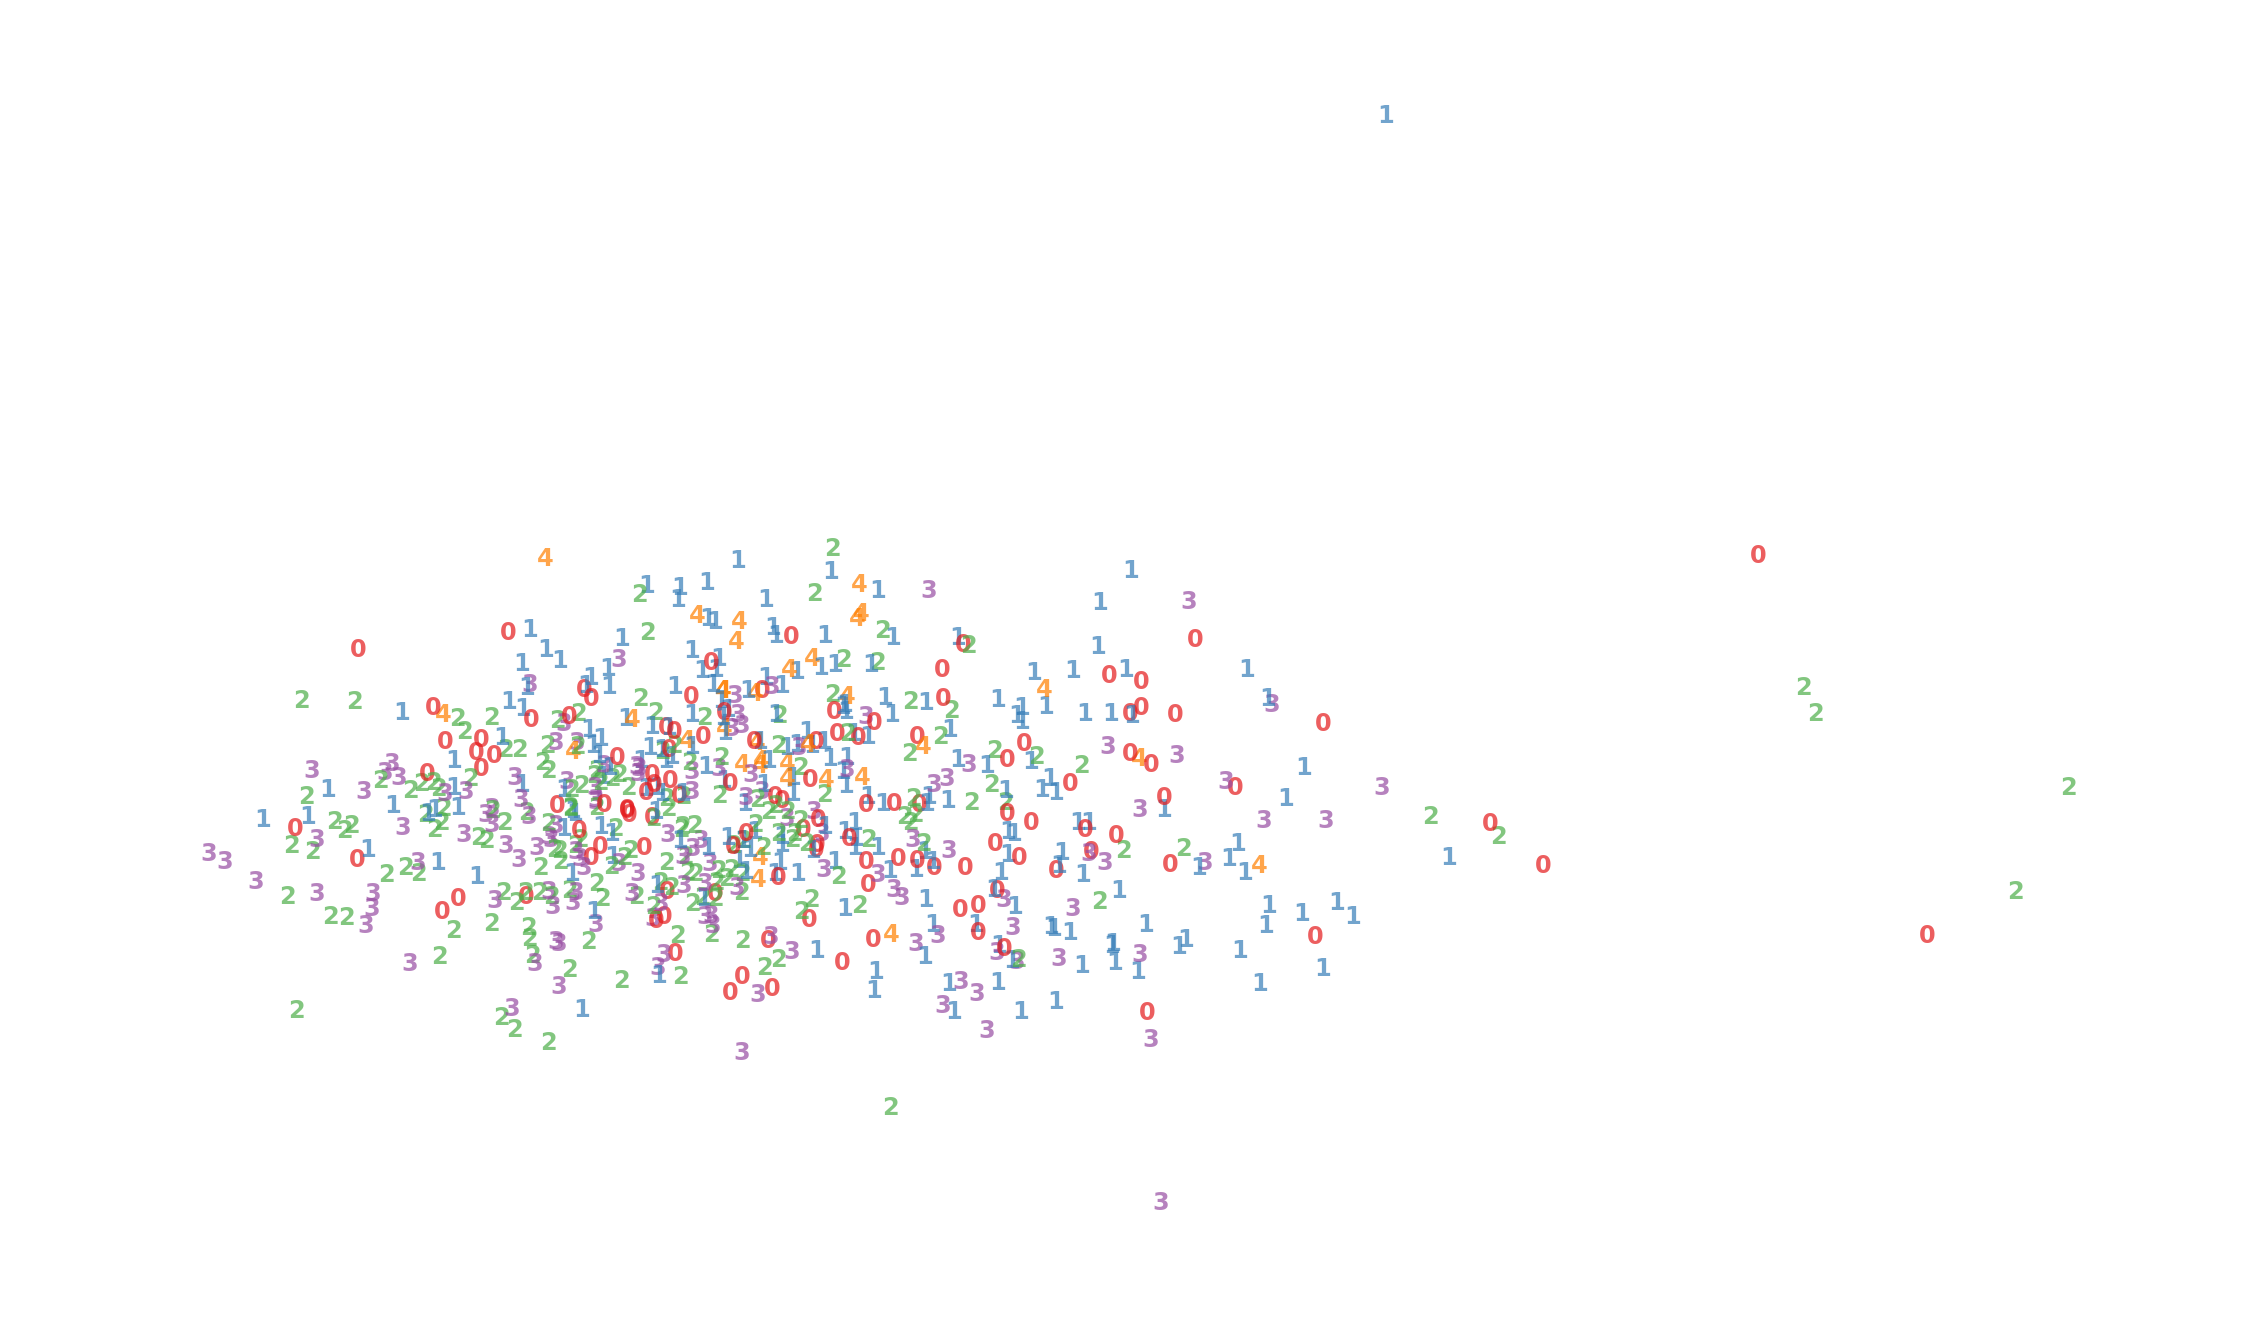

In [89]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scale)


fig, ax = plt.subplots(figsize=(20, 12))
plot_mnist_embedding(ax, X_pca[:,1:], np.argmax(y_train, axis = 1), alpha = 0.7)

/Users/Maxwell/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


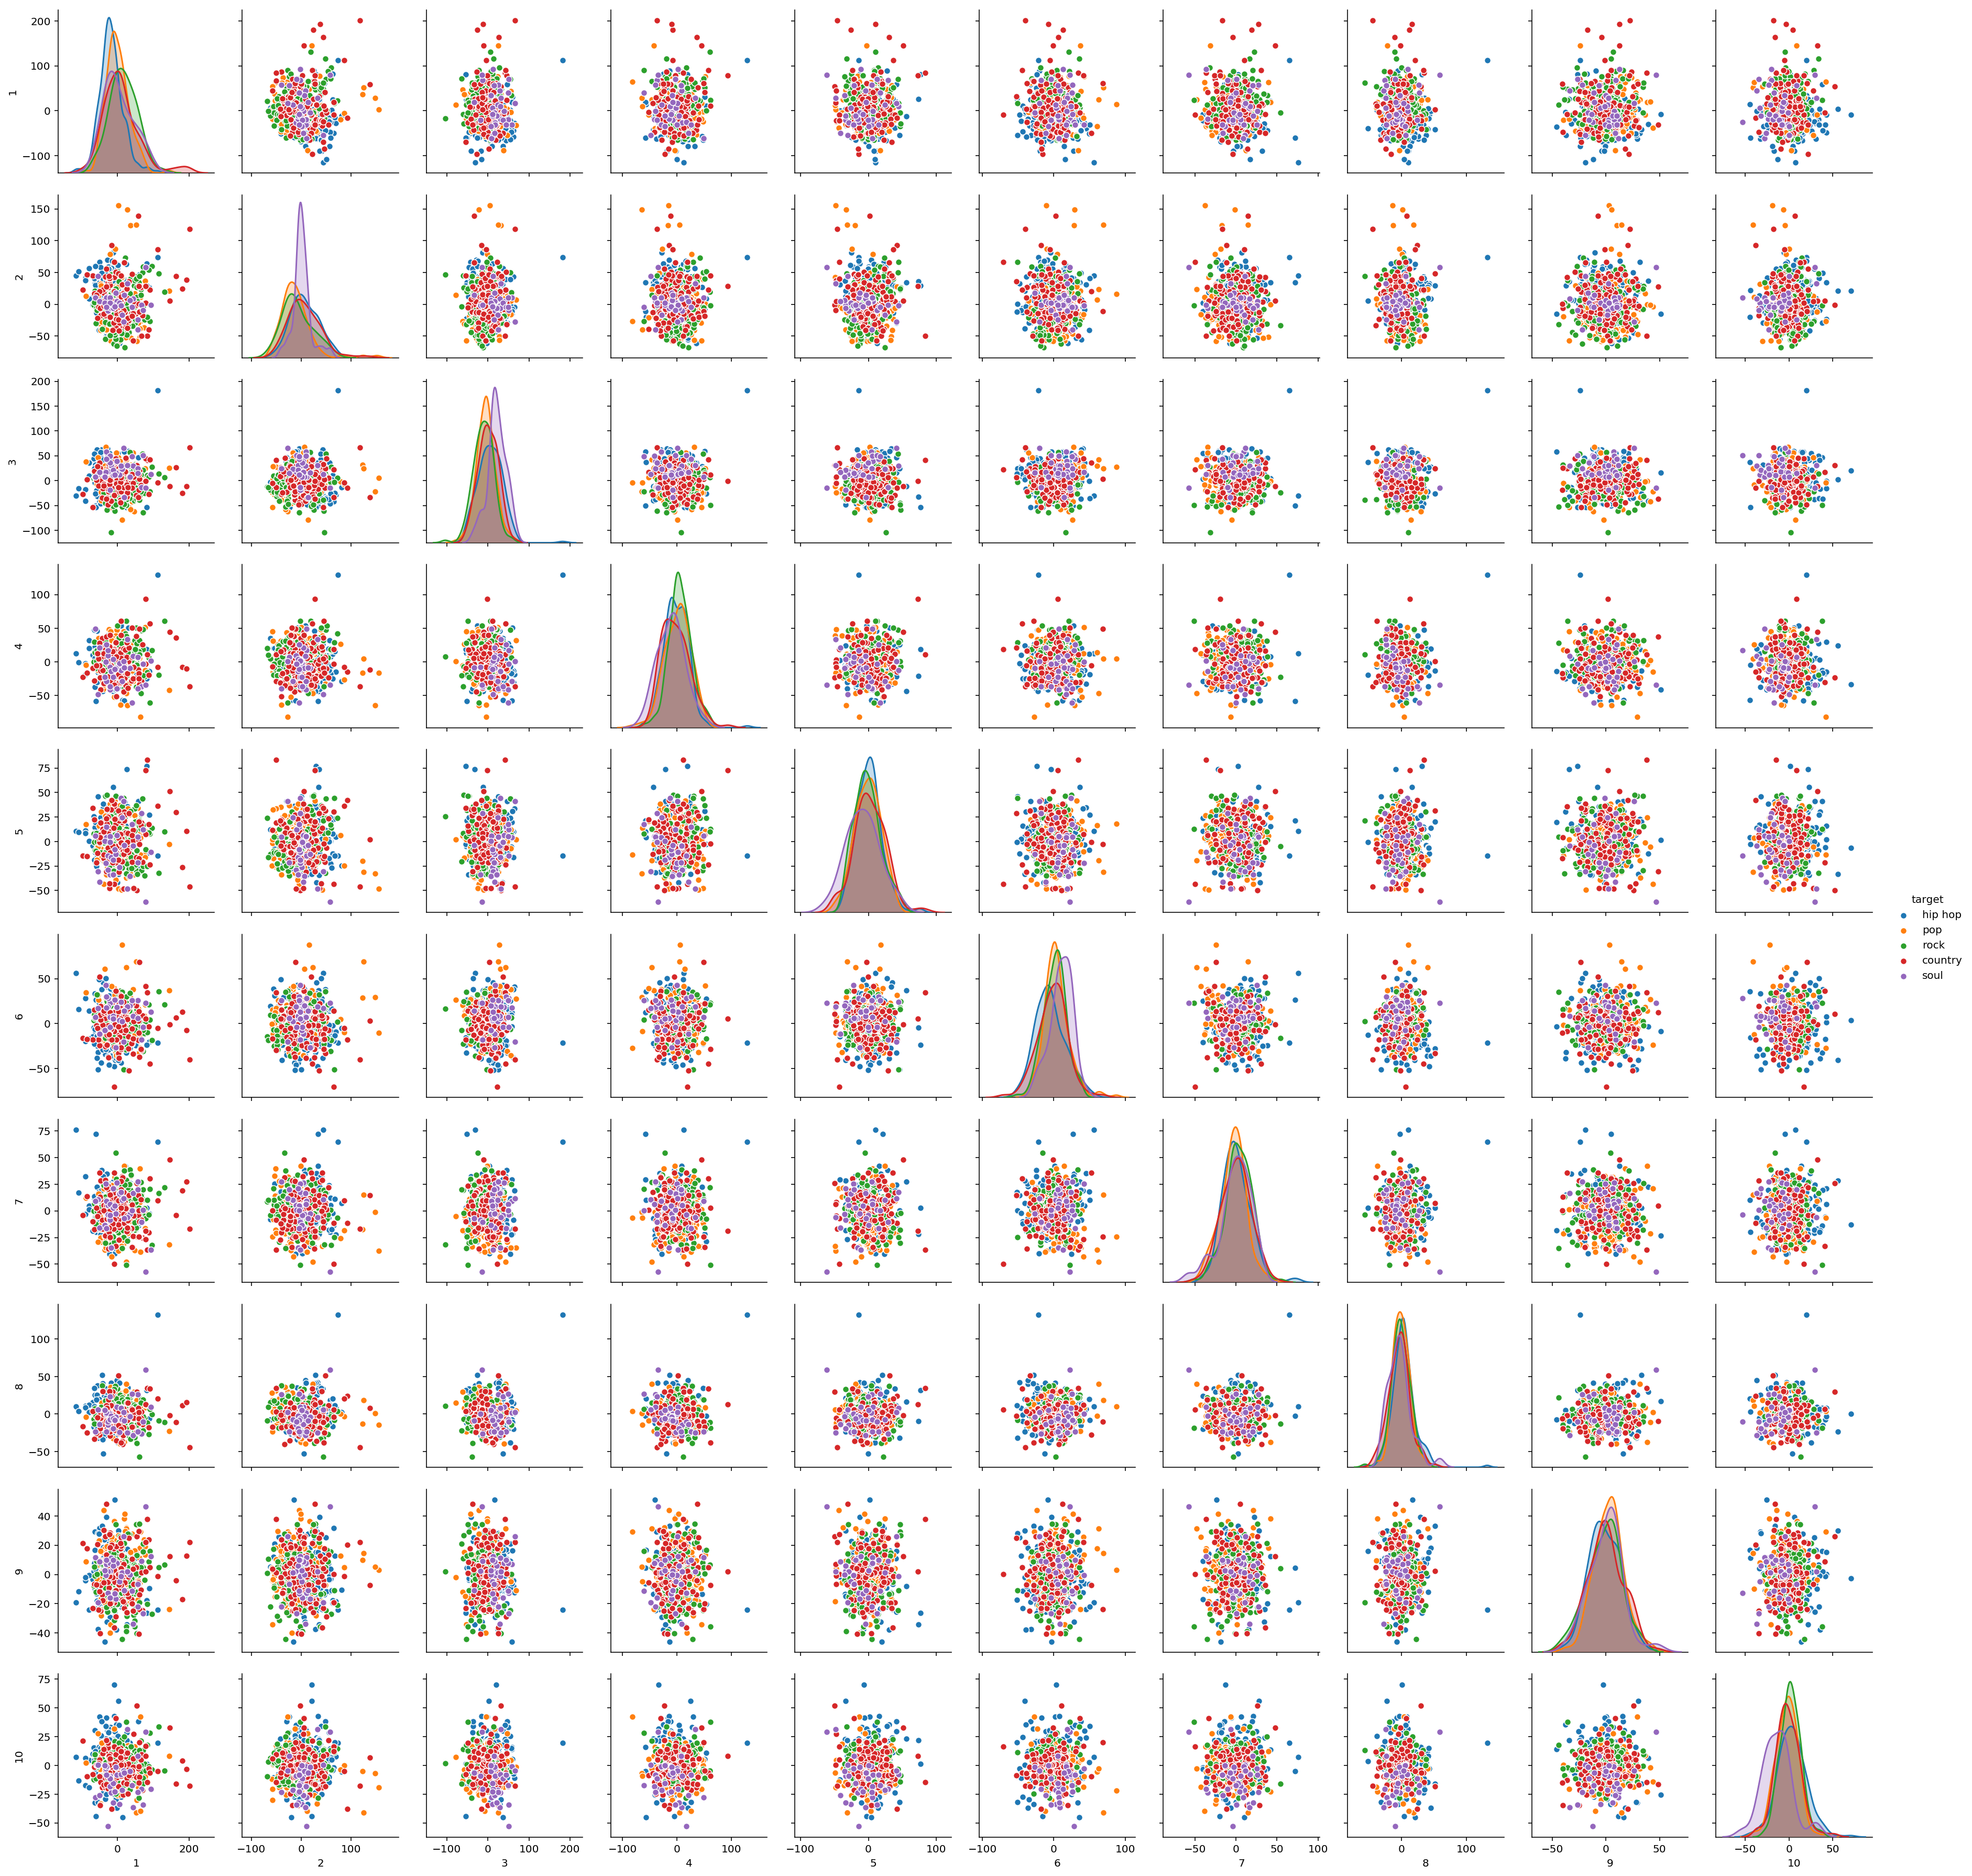

In [91]:
import seaborn as sns

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train_scale)

X_pca_df = pd.DataFrame(np.concatenate((X_pca, y_columns[np.argmax(y_train, axis = 1)].reshape(-1,1)), axis = 1), columns = [1,2,3,4,5,6,7,8,9,10,'target'])
X_pca_df.head()

# pairwise plot
sns.pairplot(X_pca_df, hue = 'target')

In [92]:
model = models.Sequential()

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(12, 80, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# # model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))

In [93]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.fit(X_train_scale, y_train, epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
